### We first start with a dummy ridge regressor that scored a RMSE of 167.1334 on the kaggle competition

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import numpy as np
model = Ridge()
# let x be the airtrain dataframe without value 
# let y be the airtrain dataframe with value
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)
airtrain = pd.get_dummies(airtrain,columns=['Gas'])


airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)
#drop airtest column id
airtest.drop(['id'],axis=1,inplace=True)
airtest = pd.get_dummies(airtest,columns=['Gas'])


X = airtrain.drop(['Value'],axis=1)
y = airtrain['Value']
model.fit(X, y)
predictions=model.predict(airtest)
predictions=pd.DataFrame(predictions)
predictions
predictions.to_csv('./predictions/1st_predictions.csv')




In [3]:
airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)
#drop airtest column id
airtest.drop(['id'],axis=1,inplace=True)
airtest.to_csv('./predictions/test.csv')

<AxesSubplot:>

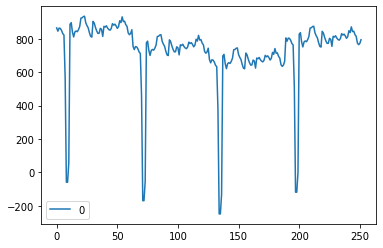

In [4]:
predictions.plot()

# Exploratory Data Analysis

In [5]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           1312 non-null   float64
 1   RH          1312 non-null   float64
 2   Gas         1312 non-null   object 
 3   Value       1312 non-null   float64
 4   Unnamed: 5  0 non-null      float64
 5   Unnamed: 6  0 non-null      float64
dtypes: float64(5), object(1)
memory usage: 71.8+ KB


### Looks like there are various types of Gases 

In [6]:
# show 5 random rows of dataframe 
# drop column index 5 and 6 dataframe
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

airtrain.sample(5)

,T,RH,Gas,Value
Date,,,,
2016-12-02,13.768750,75.313541,HC,925.725000
2016-06-17,27.325000,33.562500,O3,694.425000
2016-06-04,23.715625,31.282292,NO2,969.750000
2016-05-04,18.913889,51.195139,O3,1091.858333
2016-10-01,18.428125,42.444792,HC,656.875000


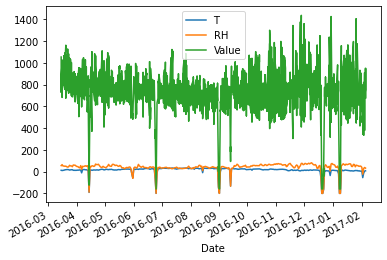

In [7]:
airtrain.plot()
plt.show()

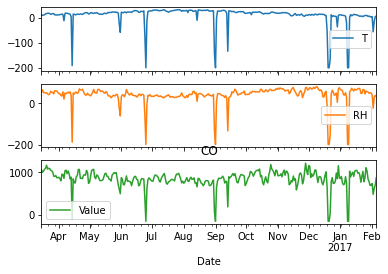

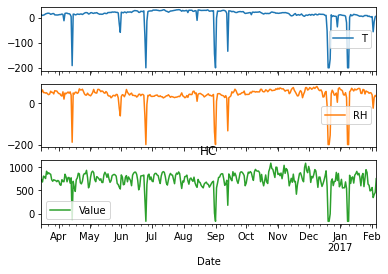

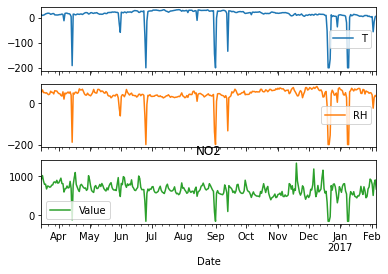

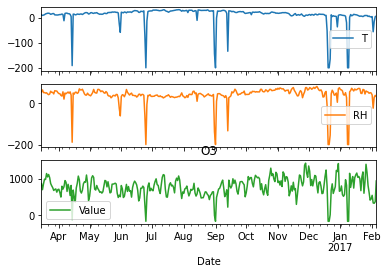

In [8]:
#plot a graph group by the Gas column with label as the Gas column
gases=airtrain.Gas.unique() #['CO' 'HC' 'NO2' 'O3']
# use a loop to filter out the gas column with the array gases

for gas in gases:
    airtrain[airtrain.Gas==gas].plot(subplots=True)
    #set title as gas at the top of each plot 
    plt.title(gas)
    plt.show()

### The attributes T, RH and Value are dropping below zero at certain points.  
There seems to be no missing values but 31 data points dropping below 0 which shouldn't be possible



In [9]:
print(airtrain.info())
airtrain[airtrain['Value']<0].count()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2016-03-15 to 2017-02-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1312 non-null   float64
 1   RH      1312 non-null   float64
 2   Gas     1312 non-null   object 
 3   Value   1312 non-null   float64
dtypes: float64(3), object(1)
memory usage: 51.2+ KB
None


T        31
RH       31
Gas      31
Value    31
dtype: int64

### We can safely assume that when T or RH is -200 , Value will always be -200

In [10]:
#np.logical_or in list comprehension of airtrain
print('Times when T or RH is -200 and Value is not -160',airtrain[((airtrain['T']==-200) | (airtrain["RH"] ==-200)) & (airtrain['Value']!=-160)].count())

#This just shows that when T or RH is -200 and Value is always -160

Times when T or RH is -200 and Value is not -160 T        0
RH       0
Gas      0
Value    0
dtype: int64


### Looks like the dataset is also normally distributed for each of its attributes

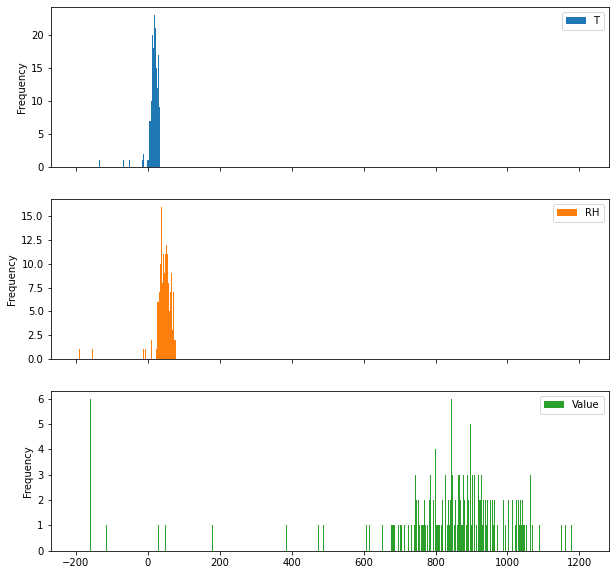

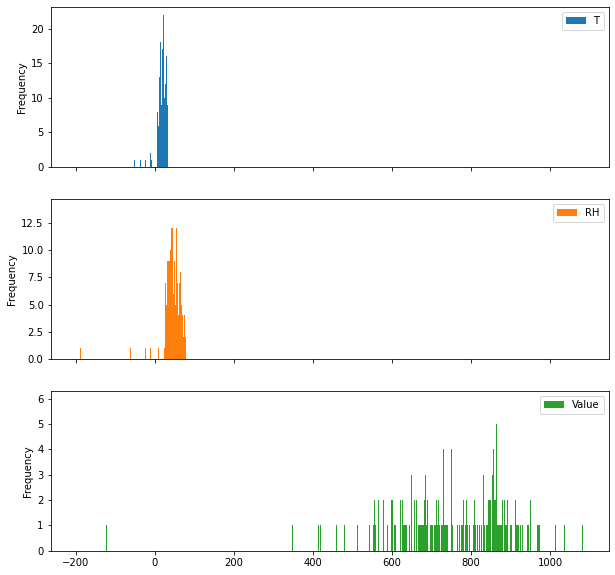

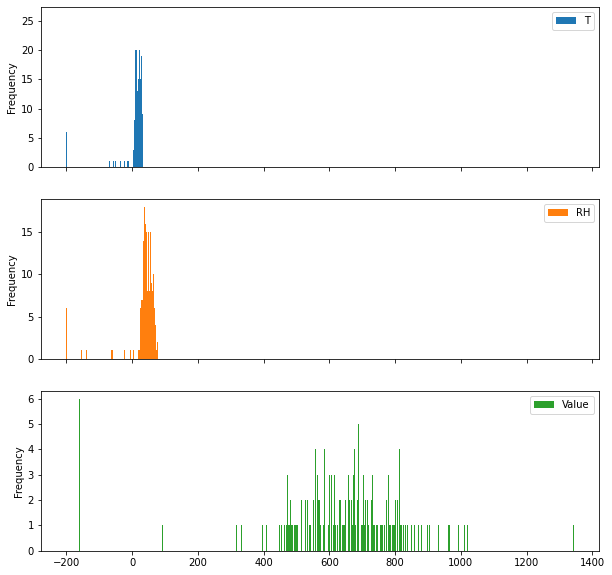

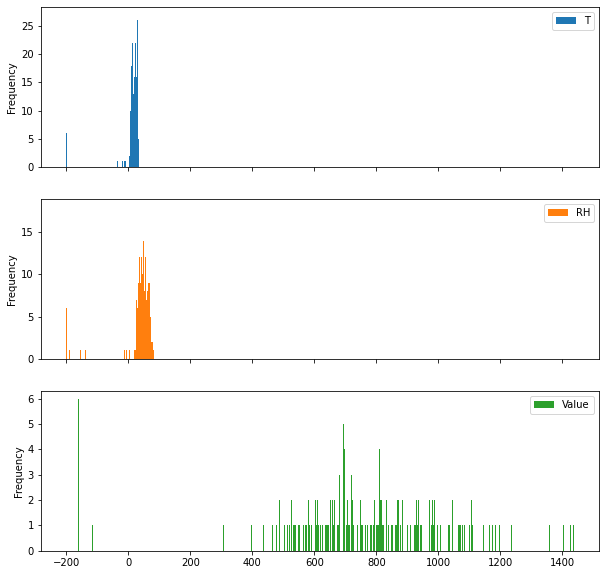

In [11]:
# plot a graph group by the Gas column with label as the Gas column
airtrain.groupby('Gas').plot(kind='hist',subplots=True,figsize=(10,10),bins = 1000)
plt.show()

### Stationarity test
[stationarity test]https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/  

We will perform both augmented dickey fuller(Adfuller) test and a Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test  
to find out whether the dataset has a unit root

In [12]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
result3 = adfuller(airtrain.Value)
print('number of observations:',result3[3],'\nAir Dataset Value attribute p-value: %f' % result3[1])

number of observations: 1288 
Air Dataset Value attribute p-value: 0.000039


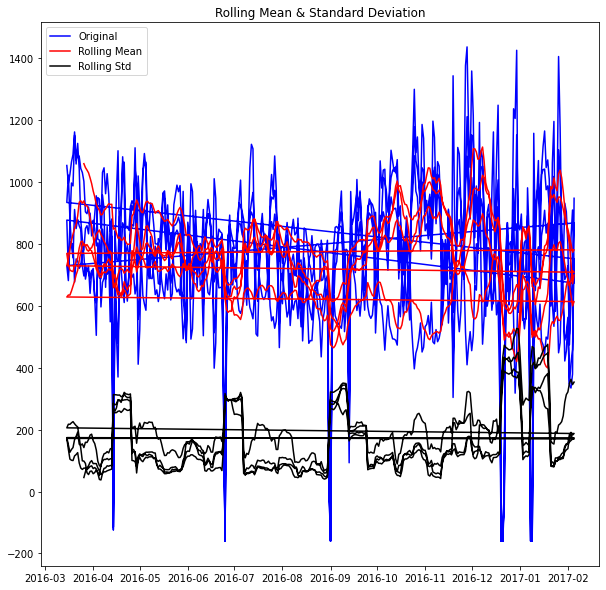

Results of Dickey-Fuller Test:
Test Statistic                   -4.874493
p-value                           0.000039
#Lags Used                       23.000000
Number of Observations Used    1288.000000
Critical Value (1%)              -3.435437
Critical Value (5%)              -2.863787
Critical Value (10%)             -2.567966
dtype: float64
Strong evidence to reject the null hypothesis, the series is stationary


In [13]:
#test for stationarity in airtrain dataframe
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=[10,10])
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # check if the p-value is less than 0.05, if yes, then we can reject the null hypothesis that the data is stationary
    if dftest[1] < 0.05:
        print('Strong evidence to reject the null hypothesis, the series is stationary')
    else:
        print('Weak evidence to reject the null hypothesis, the series is non-stationary')
        
    plt.show()

test_stationarity(airtrain.Value)

In [14]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
kpss_test(airtrain.Value,regression='c')

KPSS Statistic: 1.2249555213186396
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Differencing will be done as recommended by Statsmodels.org  
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html  

Case 1: Both tests conclude that the series is not stationary - The series is not stationary  

Case 2: Both tests conclude that the series is stationary - The series is stationary  

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.  

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.



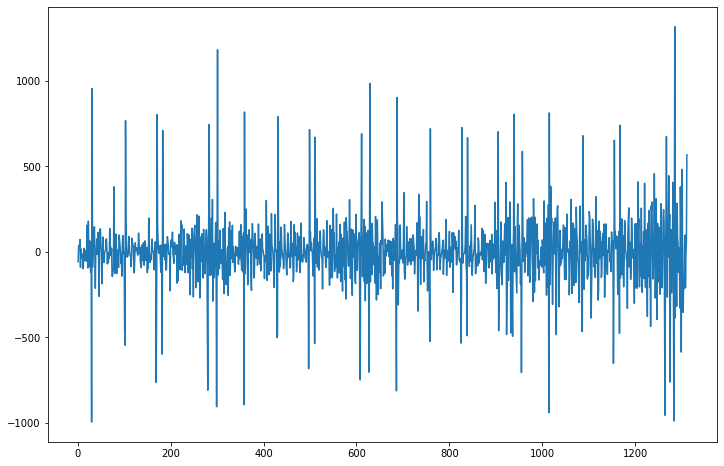

In [157]:
airtrain["Value_diff"] = airtrain["Value"] - airtrain["Value"].shift(1)
airtrain["Value_diff"].dropna().plot(figsize=(12, 8))
plt.show()

In [159]:
airtrain.sample(5)

,Date,T,RH,Gas,Value,Value_diff
450,2016-07-15,26.618056,35.734722,HC,657.655556,-134.644444
814,2016-08-20,29.814583,37.769792,NO2,826.591667,63.216667
755,2016-06-22,25.288542,42.623958,NO2,659.133333,1.177778
58,2016-05-12,15.455208,55.588889,CO,799.463889,-0.802778
790,2016-07-27,32.997917,33.087500,NO2,527.475000,-37.136111


# Feature Engineering
## Firstly we pivot the dataset for a better overview 

In [155]:
# pivot table
data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)
temp = pd.DataFrame(data['T'].groupby(['Date']).mean())
rh = pd.DataFrame(data['RH'].groupby(['Date']).mean())
pivot = pd.pivot(data, columns = 'Gas', values = 'Value')
df = temp.join([rh, pivot])
df.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)
df

,T,RH,CO_Value,HC_Value,NO2_Value,O3_Value
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,562.650000,797.647222,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,347.480556,508.180556,343.500000
2017-02-03,-14.272917,28.563542,615.700000,414.475000,819.733333,334.458333


### Correlation test using pivoted data

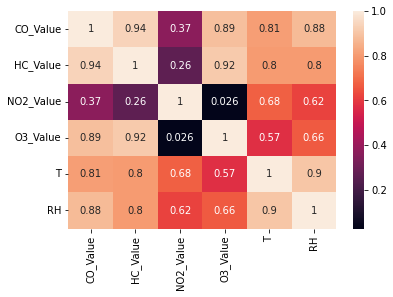

In [147]:
corr = df_pivot.corr()
sns.heatmap(corr, annot=True)
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


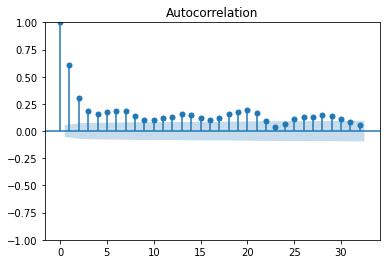

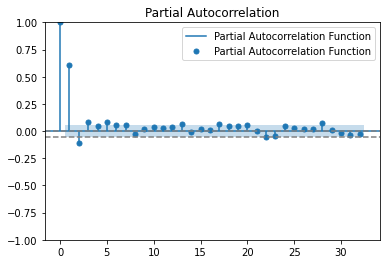

In [ ]:
#autocorrelation of airtrain dataframe

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# lag_acf = acf(airtrain.Value, nlags=365)
# lag_pacf = pacf(airtrain.Value, nlags=365, method='ols')
#Plot ACF:
plot_acf(airtrain['Value'],label='Autocorrelation Function')
plot_pacf(airtrain['Value'],label='Partial Autocorrelation Function')
# plt.plot(lag_acf,label='Autocorrelation Function')
# plt.plot(lag_pacf, label='Partial Autocorrelation Function')
plt.legend()
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airtrain.Value)),linestyle='--',color='gray')

## Value is normally distributed , adfuller and dickey-fuller result < 0.05 thus stationary

- Consistency of Mean
- Consistency of Standard Deviation
- Consistency of Auto correlation 

* Auto correlation is not very close to zero so its still possible to predict based on past data

### Is there correlation between Values of CO and Values HC 

In [46]:
# I will be transforming the data into Lets make asfreq to day and make got sure got no null
# Another way of cleaning is for each date u have the following columns:
# T_CO ,RH_CO, Value_CO, 
# T_HC ,RH_HC, Value_HC, 
# T_NO2 ,RH_NO2, Value_NO2, 
# T_O3 ,RH_O3, Value_O3 
TrainTransform = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
TrainTransform.drop(TrainTransform.columns[4:6],axis=1,inplace=True)
CO = TrainTransform[TrainTransform.Gas=='CO']
CO = pd.DataFrame(CO)
CO.index = CO.index.to_period('D')
CO.sort_index(inplace=True)
CO.drop(['Gas'],axis=1,inplace=True)
CO=CO.rename(columns={"Value":"Value_CO"})


HC = TrainTransform[TrainTransform.Gas=='HC']
HC = pd.DataFrame(HC)
HC.index = HC.index.to_period('D')
HC.sort_index(inplace=True)
HC.drop(['Gas','T','RH'],axis=1,inplace=True)
HC=HC.rename(columns={"Value":"Value_HC"})



NO2 = TrainTransform[TrainTransform.Gas=='NO2']
NO2 = pd.DataFrame(NO2)
NO2.index = NO2.index.to_period('D')
NO2.sort_index(inplace=True)
NO2.drop(['Gas','T','RH'],axis=1,inplace=True)
NO2=NO2.rename(columns={"Value":"Value_NO2"})

O3 = TrainTransform[TrainTransform.Gas=='O3']
O3 = pd.DataFrame(O3)
O3.index = O3.index.to_period('D')
O3.sort_index(inplace=True)
O3.drop(['Gas','T','RH'],axis=1,inplace=True)
O3=O3.rename(columns={"Value":"Value_O3"})

traintransformed = pd.concat([CO, HC, NO2, O3], axis=1)
traintransformed
# corr = traintransformed.corr()
# sns.heatmap(corr, annot=True)
# plt.show()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 328 entries, 2016-03-15 to 2017-02-05
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   T          328 non-null    float64
 1   RH         328 non-null    float64
 2   Value_CO   328 non-null    float64
 3   Value_HC   328 non-null    float64
 4   Value_NO2  328 non-null    float64
 5   Value_O3   328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


In [ ]:
traintransformed

,T,RH,Value_CO,Value_HC,Value_NO2,Value_O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,562.650000,797.647222,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,347.480556,508.180556,343.500000
2017-02-03,-14.272917,28.563542,615.700000,414.475000,819.733333,334.458333


### Seasonal decomposition

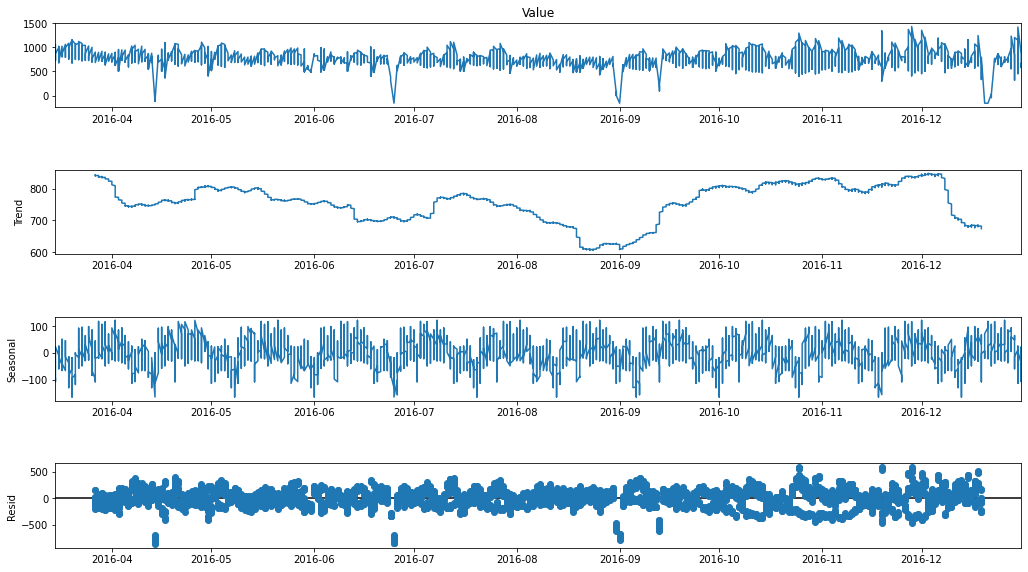

In [ ]:
#Timeseries decomposition on airtrain data
from statsmodels.tsa.seasonal import seasonal_decompose
time_decompose = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

time_decompose.drop(time_decompose.columns[4:6],axis=1,inplace=True)

dummy = pd.get_dummies(time_decompose['Gas'])
# Join the encoded df
time_decompose = time_decompose.join(dummy)
time_decompose = time_decompose.drop('Gas',axis = 1)

# only take 2016 
time_decompose=time_decompose.loc['2016']
time_decompose.sort_index()
decompose_result_mult = seasonal_decompose(time_decompose['Value'], model="additive",period = int(len(time_decompose['Value'])/12))
# Period is the number of months in the data set
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig=decompose_result_mult.plot()
fig.set_size_inches((16, 9))
plt.show()




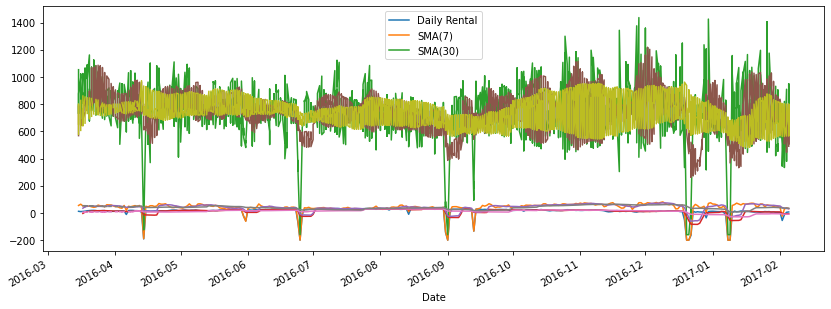

In [ ]:
# rolling 
daily_rental = airtrain
ax = daily_rental.plot(figsize=(14, 5))
daily_rental.rolling(window=7).mean().plot(ax=ax)
daily_rental.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Daily Rental', 'SMA(7)', 'SMA(30)'])
plt.show()

In [ ]:
daily_rental

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000
2016-03-16,9.833333,64.069791,CO,995.250000
2016-03-17,11.292708,51.107292,CO,1025.250000
2016-03-18,12.866319,51.530903,CO,1064.444444
2016-03-19,16.016667,48.843750,CO,1088.741667
...,...,...,...,...
2017-02-01,5.267708,39.614930,O3,553.180556
2017-02-02,-55.515972,-24.010417,O3,343.500000
2017-02-03,-14.272917,28.563542,O3,334.458333


In [ ]:
# pip install statsmodels

In [ ]:
# pip install pmdarima

# Holts Winter Exponential Smoothing Function

In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
model = Ridge()
# let x be the airtrain dataframe without value 
# let y be the airtrain dataframe with value
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)
CO = airtrain[airtrain.Gas=='CO'].drop(['Gas'],axis=1).Value
HC = airtrain[airtrain.Gas=='HC'].drop(['Gas'],axis=1).Value
NO2 = airtrain[airtrain.Gas=='NO2'].drop(['Gas'],axis=1).Value
O3 = airtrain[airtrain.Gas=='O3'].drop(['Gas'],axis=1).Value


airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)
#drop airtest column id
airtest.drop(['id'],axis=1,inplace=True)
# airtest = pd.get_dummies(airtest,columns=['Gas'])

# X = airtrain.drop(['Value'],axis=1)
# y = airtrain['Value']
# model.fit(X, y)
# predictions=model.predict(airtest)
# predictions=pd.DataFrame(predictions)
# predictions
# predictions.to_csv('1st_predictions.csv')
print(CO)


Date
2016-03-15    1053.200000
2016-03-16     995.250000
2016-03-17    1025.250000
2016-03-18    1064.444444
2016-03-19    1088.741667
                 ...     
2017-02-01     729.422222
2017-02-02     474.291667
2017-02-03     615.700000
2017-02-04     691.713889
2017-02-05     867.600000
Name: Value, Length: 328, dtype: float64


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from sklearn.metrics import mean_absolute_percentage_error
CO_model = HWES(CO, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
CO_pred = CO_model.predict(start='2017-02-06', end='2017-04-10')

HC_model = HWES(HC, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
HC_pred = HC_model.predict(start='2017-02-06', end='2017-04-10')


NO2_model = HWES(NO2, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
N02_pred = NO2_model.predict(start='2017-02-06', end='2017-04-10')

O3_model = HWES(O3, seasonal_periods=63, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
O3_pred = O3_model.predict(start='2017-02-06', end='2017-04-10')
# fig, ax = plt.subplots(figsize=(14, 5))
# ax.plot(train_data, label='training')
# ax.plot(test_data, label='testing')
# ax.plot(pred1, label='prediction')
# plt.legend()
# plt.title('Holt-Winters Exponential Smoothing')
# plt.show()
# # Evaluation
# from sklearn.metrics import mean_absolute_percentage_error
# mape_train = mean_absolute_percentage_error(train_data, pred1[pred1.index<'2012-11'])
# mape_test = mean_absolute_percentage_error(test_data, pred1[pred1.index>='2012-11'])
# print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%'
# )
# print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

In [ ]:
#drop first column of CO_pred 
CO_pred = CO_pred.drop(CO_pred.index[0])
HC_pred = HC_pred.drop(HC_pred.index[0])
N02_pred = N02_pred.drop(N02_pred.index[0])
O3_pred = O3_pred.drop(O3_pred.index[0])

#concatenate CO_pred, HC_pred, N02_pred, O3_pred
pred = pd.concat([CO_pred, HC_pred, N02_pred, O3_pred], axis=0)
#create index 0 to len(pred)
pred.index = range(len(pred))

pred.to_csv('./predictions/pred.csv')


In [ ]:
X = airtrain.drop(['Value'],axis=1)
X


,T,RH,Gas
Date,,,
2016-03-15,12.020833,54.883334,CO
2016-03-16,9.833333,64.069791,CO
2016-03-17,11.292708,51.107292,CO
2016-03-18,12.866319,51.530903,CO
2016-03-19,16.016667,48.843750,CO
...,...,...,...
2017-02-01,5.267708,39.614930,O3
2017-02-02,-55.515972,-24.010417,O3
2017-02-03,-14.272917,28.563542,O3


In [ ]:
# Code a function in which it tests how good a model is by comparing the actual values to the predicted values
def test_model(model, X, y):
    from sklearn.metrics import mean_absolute_percentage_error
    pred = model.predict(X)
    mape = mean_absolute_percentage_error(y, pred)
    return mape

{'fit_intercept': True, 'normalize': True}
-20707.725875836488
-20707.726 (+/-3314.783) for {'fit_intercept': True, 'normalize': True}
-20713.471 (+/-3277.868) for {'fit_intercept': True, 'normalize': False}
-20713.471 (+/-3277.868) for {'fit_intercept': False, 'normalize': True}
-20713.471 (+/-3277.868) for {'fit_intercept': False, 'normalize': False}
23587.395580883443
116.90069206155931
0.4447814330087002
[  1.35966954   2.54180525  90.17783487 -16.71061921 -95.89798007
  22.43076441]
634.2587537037152
[ 785.20123059  801.78025694  782.7713237   108.00815861  573.00548737
  745.9828272   861.83981988   69.17703041  698.78322575  744.15104314
  785.12421083  739.86940391  817.65905674  774.4240419   794.26109429
  844.54115369  681.0866347   766.59018018  653.19027946  890.3872668
  807.31818472  771.98046689  800.99567735  683.10438426  902.56701279
  837.05185274  817.19958163  628.90981031  819.55612992  726.21702162
  801.94865207  812.6559096   889.65977778  421.57151986  711.47

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


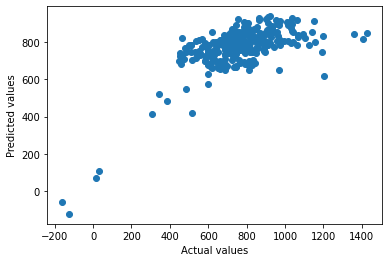

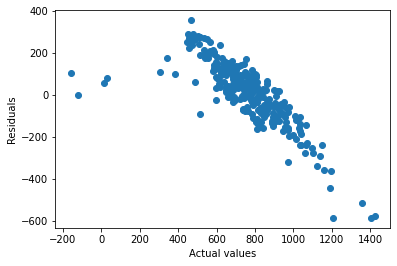

In [ ]:
# simple linear regression
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
airtrain = pd.get_dummies(airtrain,columns=['Gas'])
X = airtrain.drop(['Value'],axis=1)
y = airtrain['Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# importing module
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# use gridsearch cv to tune LinearRegression parameters 
from sklearn.model_selection import GridSearchCV
# creating an object of GridSearchCV class
grid_search = GridSearchCV(estimator = LR,
                            param_grid = {'fit_intercept':[True,False],
                                            'normalize':[True,False]},                              
                            cv = 5,
                            n_jobs = -1,
                            scoring = 'neg_mean_squared_error')
# fitting the model
grid_search.fit(X_train, y_train)
# printing the best parameters
print(grid_search.best_params_)
# printing the best score
print(grid_search.best_score_)
# printing the score for each parameter combination
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the model
LR.fit(X_train, y_train)
# predicting the test set
y_pred = LR.predict(X_test)
# calculating the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(mse)
# calculating the mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(mae)
# calculating the root mean squared error
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)
# printing the coefficients and intercept
print(LR.coef_)
print(LR.intercept_)
# printing the prediction
print(LR.predict(X_test))
# printing the actual values
print(y_test)
# plotting the actual values vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
# plotting the residuals
plt.scatter(y_test, y_pred - y_test)
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.show()


# # fitting the training data
# LR.fit(X_train,y_train)
# y_prediction = LR.predict(X_test)
# y_prediction
# # importing r2_score module
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error
# # predicting the accuracy score
# score=r2_score(y_test,y_prediction)
# print('r2 sccre is ',score)
# print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
# print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))


In [ ]:
airtest = pd.get_dummies(airtest,columns=['Gas'])
predictions1 = LR.predict(airtest)
predictions1

array([ 864.93177543,  846.45181698,  863.84436627,  862.11124431,
        850.47121387,  832.29925011,  824.34499803,  570.32529391,
        -55.85836982,  -55.85836982,   60.2147509 ,  886.06582942,
        896.10097322,  842.1212413 ,  813.39505825,  841.57128952,
        847.48574652,  843.23856569,  854.84042565,  873.4050159 ,
        921.10712483,  922.82287017,  929.52480268,  931.67551871,
        894.55442414,  877.75015596,  865.04458075,  836.82140721,
        815.57473436,  811.70209044,  902.10783652,  892.27526484,
        867.63843208,  847.87282686,  833.4965467 ,  834.26085068,
        862.70587431,  857.82842209,  815.38097933,  875.18756558,
        870.84920011,  878.44652486,  865.36776827,  857.4845448 ,
        853.67469123,  862.6621468 ,  890.68338654,  882.46385772,
        888.18033114,  878.61127498,  864.37807378,  873.74026794,
        907.96136257,  897.38574045,  929.79543758,  903.25319838,
        905.02600176,  885.46272784,  875.6303632 ,  837.48485

In [ ]:
predictions = pd.DataFrame(predictions1)
predictions.to_csv('./predictions/3rdpredictions.csv')

In [ ]:
# I will be transforming the data into Lets make asfreq to day and make got sure got no null
# Another way of cleaning is for each date u have the following columns:
# T_CO ,RH_CO, Value_CO, 
# T_HC ,RH_HC, Value_HC, 
# T_NO2 ,RH_NO2, Value_NO2, 
# T_O3 ,RH_O3, Value_O3 
TrainTransform = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
TrainTransform.drop(TrainTransform.columns[4:6],axis=1,inplace=True)
CO = TrainTransform[TrainTransform.Gas=='CO']
CO = pd.DataFrame(CO)
CO.index = CO.index.to_period('D')
CO.sort_index(inplace=True)
CO.drop(['Gas'],axis=1,inplace=True)
CO=CO.rename(columns={"T":"T_CO","RH":"RH_CO","Value":"Value_CO"})


HC = TrainTransform[TrainTransform.Gas=='HC']
HC = pd.DataFrame(HC)
HC.index = HC.index.to_period('D')
HC.sort_index(inplace=True)
HC.drop(['Gas'],axis=1,inplace=True)
HC=HC.rename(columns={"T":"T_HC","RH":"RH_HC","Value":"Value_HC"})



NO2 = TrainTransform[TrainTransform.Gas=='NO2']
NO2 = pd.DataFrame(NO2)
NO2.index = NO2.index.to_period('D')
NO2.sort_index(inplace=True)
NO2.drop(['Gas'],axis=1,inplace=True)
NO2=NO2.rename(columns={"T":"T_NO2","RH":"RH_NO2","Value":"Value_NO2"})

O3 = TrainTransform[TrainTransform.Gas=='O3']
O3 = pd.DataFrame(O3)
O3.index = O3.index.to_period('D')
O3.sort_index(inplace=True)
O3.drop(['Gas'],axis=1,inplace=True)
O3=O3.rename(columns={"T":"T_O3","RH":"RH_O3","Value":"Value_O3"})

traintransformed = pd.concat([CO, HC, NO2, O3], axis=1)






TestTransform = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
TestTransform.drop(['id'],axis=1,inplace=True)
TestTransform.drop(TestTransform.columns[3:],axis=1,inplace=True)
CO = TestTransform[TestTransform.Gas=='CO']
CO = pd.DataFrame(CO)
CO.index = CO.index.to_period('D')
CO.sort_index(inplace=True)
CO.drop(['Gas'],axis=1,inplace=True)
CO=CO.rename(columns={"T":"T_CO","RH":"RH_CO","Value":"Value_CO"})


HC = TestTransform[TestTransform.Gas=='HC']
HC = pd.DataFrame(HC)
HC.index = HC.index.to_period('D')
HC.sort_index(inplace=True)
HC.drop(['Gas'],axis=1,inplace=True)
HC=HC.rename(columns={"T":"T_HC","RH":"RH_HC","Value":"Value_HC"})



NO2 = TestTransform[TestTransform.Gas=='NO2']
NO2 = pd.DataFrame(NO2)
NO2.index = NO2.index.to_period('D')
NO2.sort_index(inplace=True)
NO2.drop(['Gas'],axis=1,inplace=True)
NO2=NO2.rename(columns={"T":"T_NO2","RH":"RH_NO2","Value":"Value_NO2"})

O3 = TestTransform[TestTransform.Gas=='O3']
O3 = pd.DataFrame(O3)
O3.index = O3.index.to_period('D')
O3.sort_index(inplace=True)
O3.drop(['Gas'],axis=1,inplace=True)
O3=O3.rename(columns={"T":"T_O3","RH":"RH_O3","Value":"Value_O3"})

testtransformed = pd.concat([CO, HC, NO2, O3], axis=1)

traintransformed

,T_CO,RH_CO,Value_CO,T_HC,RH_HC,Value_HC,T_NO2,RH_NO2,Value_NO2,T_O3,RH_O3,Value_O3
Date,,,,,,,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,12.020833,54.883334,729.800000,12.020833,54.883334,933.800000,12.020833,54.883334,876.833333
2016-03-16,9.833333,64.069791,995.250000,9.833333,64.069791,681.441667,9.833333,64.069791,1021.750000,9.833333,64.069791,708.025000
2016-03-17,11.292708,51.107292,1025.250000,11.292708,51.107292,806.583333,11.292708,51.107292,881.375000,11.292708,51.107292,867.375000
2016-03-18,12.866319,51.530903,1064.444444,12.866319,51.530903,794.258333,12.866319,51.530903,794.527778,12.866319,51.530903,996.625000
2016-03-19,16.016667,48.843750,1088.741667,16.016667,48.843750,755.083333,16.016667,48.843750,800.883333,16.016667,48.843750,987.341667
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,5.267708,39.614930,562.650000,5.267708,39.614930,797.647222,5.267708,39.614930,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,-55.515972,-24.010417,347.480556,-55.515972,-24.010417,508.180556,-55.515972,-24.010417,343.500000
2017-02-03,-14.272917,28.563542,615.700000,-14.272917,28.563542,414.475000,-14.272917,28.563542,819.733333,-14.272917,28.563542,334.458333


In [ ]:
testtransformed

,T_CO,RH_CO,T_HC,RH_HC,T_NO2,RH_NO2,T_O3,RH_O3
Date,,,,,,,,
2017-02-06,6.616667,51.734375,6.616667,51.734375,6.616667,51.734375,6.616667,51.734375
2017-02-07,7.613194,43.930903,7.613194,43.930903,7.613194,43.930903,7.613194,43.930903
2017-02-08,7.252083,50.966667,7.252083,50.966667,7.252083,50.966667,7.252083,50.966667
2017-02-09,7.473611,50.166319,7.473611,50.166319,7.473611,50.166319,7.473611,50.166319
2017-02-10,5.571875,46.604167,5.571875,46.604167,5.571875,46.604167,5.571875,46.604167
...,...,...,...,...,...,...,...,...
2017-04-05,17.554167,50.092708,17.554167,50.092708,17.554167,50.092708,17.554167,50.092708
2017-04-06,15.919792,35.959722,15.919792,35.959722,15.919792,35.959722,15.919792,35.959722
2017-04-07,15.489583,32.213542,15.489583,32.213542,15.489583,32.213542,15.489583,32.213542


In [ ]:


# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data

X = traintransformed.drop(['Value_CO','Value_HC','Value_NO2','Value_O3'],axis=1)
y = traintransformed[['Value_CO','Value_HC','Value_NO2','Value_O3']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# importing module
from sklearn.tree import DecisionTreeRegressor
# creating an object of LinearRegression class
LR = DecisionTreeRegressor()
# use gridsearch cv to tune LinearRegression parameters 
from sklearn.model_selection import GridSearchCV
# creating an object of GridSearchCV class
grid_search = GridSearchCV(estimator = LR,
                            param_grid = {'criterion':["squared_error", "friedman_mse", "absolute_error", "poisson"],
                                            'max_depth':[2,3,4,5,6,7,8,9,10]
                                            },                              
                            cv = 5,
                            n_jobs = -1,
                            scoring = 'r2')
# fitting the model
grid_search.fit(X_train, y_train)
# printing the best parameters
print(grid_search.best_params_)
# printing the best score
print(grid_search.best_score_)
# printing the score for each parameter combination









# means = grid_search.cv_results_['mean_test_score']
# stds = grid_search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# # creating an object of LinearRegression class
# LR = LinearRegression()
# # fitting the model
# LR.fit(X_train, y_train)
# # predicting the test set
# y_pred = LR.predict(X_test)
# # calculating the mean squared error
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_test, y_pred)
# print(mse)
# # calculating the mean absolute error
# from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_test, y_pred)
# print(mae)
# # calculating the root mean squared error
# from sklearn.metrics import r2_score
# r2 = r2_score(y_test, y_pred)
# print(r2)
# # printing the coefficients and intercept
# print(LR.coef_)
# print(LR.intercept_)
# # printing the prediction
# print(LR.predict(X_test))
# # printing the actual values
# print(y_test)
# # plotting the actual values vs predicted values
# plt.scatter(y_test, y_pred)
# plt.xlabel('Actual values')
# plt.ylabel('Predicted values')
# plt.show()
# # plotting the residuals
# plt.scatter(y_test, y_pred - y_test)
# plt.xlabel('Actual values')
# plt.ylabel('Residuals')
# plt.show()



{'criterion': 'squared_error', 'max_depth': 3}
0.6075724806043633


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pac

In [ ]:
print(type(grid_search.best_params_))

<class 'dict'>


In [ ]:
DTR = DecisionTreeRegressor(criterion= 'absolute_error')
# fitting the model
DTR.fit(X,y)
# predicting the test set
y_pred = DTR.predict(testtransformed)

In [ ]:
y_pred=pd.DataFrame(y_pred)
#concat y_pred column 1 to y_pred column 0 axis 0
y_pred=pd.concat([y_pred[0],y_pred[1],y_pred[2],y_pred[3]],axis=0)

In [ ]:
# y_pred=pd.DataFrame(y_pred)
y_pred.reset_index(inplace=True,drop=True)
y_pred.columns=['Value']
y_pred=pd.DataFrame(y_pred)

[8, 9, 71, 72, 134, 135, 197, 198]

In [ ]:
#if index of y_pred is in (id) then y_pred value is -200
extract200 = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
extract200.drop(extract200.columns[3:],axis=1,inplace=True)
#extract the id column of extract200 where "T" or "RH" == -200
id=extract200[((extract200['T']==-200) | (extract200["RH"] ==-200))].id
id=list(id)
id
for i in range(len(y_pred)):
    if y_pred.index.any() in id:
        y_pred.iloc[i,"Value"]=-160
# y_pred= y_pred.loc[y_pred.index==(id),'Value']=-200
# y_pred

In [ ]:
y_pred.to_csv('./predictions/y_pred.csv')

<AxesSubplot:>

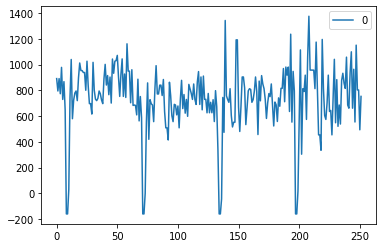

In [ ]:
y_pred.plot()

In [ ]:
RR = Ridge(alpha=0.1)
# fitting the model
RR.fit(X,y)
# predicting the test set
pred = RR.predict(testtransformed)
pred=pd.DataFrame(pred)
#concat y_pred column 1 to y_pred column 0 axis 0
pred=pd.concat([pred[0],pred[1],pred[2],pred[3]],axis=0)
# y_pred=pd.DataFrame(y_pred)
pred.reset_index(inplace=True,drop=True)
pred.columns=['Value']
pred=pd.DataFrame(pred)
for i in range(len(pred)):
    if pred.index.any() in id:
        pred.iloc[i,"Value"]=-160

<AxesSubplot:>

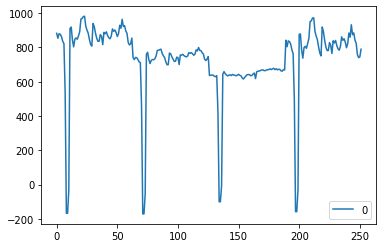

In [ ]:
pred.plot()

In [ ]:
pred.to_csv('./predictions/newpred.csv')